In [345]:
import torch, torch.nn as nn
import snntorch as snn
from snntorch import surrogate, utils, spikegen
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize
from statistics import mean
import matplotlib.pyplot as plt
from math import tan, cos, atan, pi, sqrt, radians, degrees
from time import sleep

In [346]:
num_steps = 25 # number of time steps
batch_size = 1
beta = 0.8  # neuron decay rate
spike_grad = surrogate.fast_sigmoid() # surrogate gradient

Данные об отдельных объектах представляют собой точки в пространстве. По их динамике нам нужно делать вывод, собираются ли они в нас врезаться. Сначала смоделируем движение одной точки в пространстве. Для этого нужен простенький генератор: считаем, что мы в центре цилиндрической системы координат, рандомим начальное положение точки, после этого с шансом 50/50 решаем, точка будет врезаться в нас или нет. Если нет, то рандомим конечное положение и добавляем промежуточных точек. Если да, то то же, но конечное положение - центр координат. 

In [347]:
import random
import numpy as np
camera_pos = {'r' : 0, 'phi' : 0, 'h' : 0}
field_depth_m = 20
field_height_m = 2
fov_deg = 120
img_size = (64, 64)

In [348]:
from IPython.display import clear_output
%matplotlib inline

def live_imshow(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.imshow(data)
    plt.title(title)
    plt.show();

In [349]:
class single_data:
    full_circle = 360

    def __init__(
        self,
        field_depth_m,
        field_height_m,
        fov_deg,
        camera_pos: dict,
        output_length=50,
        camera_size_r=0.5,
        camera_size_h=0.5,
        time_steps=5,
        object_r=0.5,
        img_size: tuple = (256, 256),
    ):

        start_pos = {
            "r": random.random() * field_depth_m,
            "phi": random.random() * fov_deg,
            "h": random.random() * fov_deg,
        }
        if(random.randint(0, 1)):
            self.crashes_flag = False
            end_pos = {
                "r": random.random() * field_depth_m,
                "phi": random.random() * fov_deg,
                "h": random.random() * fov_deg,
            }
        else:
            self.crashes_flag = True
            end_pos = {
                "r": random.random() * field_depth_m / field_depth_m / 4 ,
                "phi": random.random() * fov_deg,
                "h": random.random() * fov_deg,
            }

        flat_sequence = np.array(
            [
                np.linspace(start=start_pos["r"], stop=end_pos["r"], num=output_length),
                np.linspace(
                    start=start_pos["phi"], stop=end_pos["phi"], num=output_length
                ),
                np.linspace(start=start_pos["h"], stop=end_pos["h"], num=output_length),
            ]
        )
        # flat_sequence = normalize(flat_sequence)
        flat_sequence = flat_sequence.transpose()

        self.position_sequence = torch.tensor(flat_sequence, dtype=torch.float32)

        self.generate_image_sequence(field_depth_m, field_height_m, fov_deg, img_size=img_size)

    def generate_image_sequence(
        self,
        field_depth_m,
        field_height_m,
        fov_deg,
        object_r=0.5,
        img_size: tuple = (256, 256),
    ):
        self.image_sequence = []
        for timestep in self.position_sequence:
            app_matrix = torch.zeros(img_size[0], img_size[1], dtype=torch.float32)

            alpha_x = (
                radians(timestep[1] - (fov_deg / 2))
            )  # угол по горизонтали от центра взгляда в радианах
            alpha_x_max = radians(fov_deg / 2)
            img_max_x = tan(alpha_x_max) * timestep[0]

            alpha_y = (
                radians(timestep[2] - (fov_deg / 2))
            )  # угол по вертикали от центра взгляда в радианах
            alpha_y_max = radians(fov_deg / 2)
            img_max_y = tan(alpha_y_max) * timestep[0]

            img_x_from_center = (
                tan(alpha_x)
                * timestep[0]
                * cos(abs(alpha_x))
                * cos(alpha_y)
            )
            img_y_from_center = (
                tan(alpha_y)
                * timestep[0]
                * cos(abs(alpha_y))
                * cos(alpha_x)
            )  #
            x_c = torch.round(
                (img_x_from_center / img_max_x) * ((img_size[0] - 1) / 2)
                + ((img_size[0] - 1) / 2)
            )
            y_c = torch.round(
                (img_y_from_center / img_max_y) * ((img_size[1] - 1) / 2)
                + ((img_size[1] - 1) / 2)
            )
            radius_x = torch.round(
                object_r
                / (timestep[0] * tan(alpha_x_max))
                * img_size[0]
            )
            radius_y = torch.round(
                object_r
                / (timestep[0] * tan(alpha_y_max))
                * img_size[1]
            )
            try:
                x_c = int(x_c.item())
                y_c = int(y_c.item())
            except ValueError: 
                x_c = int(img_size[0] / 2)
                y_c = int(img_size[1] / 2)
            try: 
                radius_x = int(radius_x.item())
                radius_y = int(radius_y.item())
            except OverflowError:
                radius_x = img_size[0]
                radius_y = img_size[1]

            app_matrix[x_c][y_c] = 1
            for y in range(-radius_y, radius_y):
                cos_rad = sqrt(1 - (y / radius_y) ** 2)
                for x in range(-round(radius_x * cos_rad), round(radius_x * cos_rad)):
                # for x in range(-radius_x, radius_x):
                    if (x_c + x) in range(0, img_size[0]) and (y_c + y) in range(
                        0, img_size[1]
                    ):
                        app_matrix[x_c + x][y_c + y] = 1

            self.image_sequence += [app_matrix]
        self.image_sequence = torch.stack(self.image_sequence).unsqueeze(1)

In [350]:
sin_data = single_data(
    field_depth_m,
    field_height_m,
    fov_deg,
    camera_pos,
    output_length=num_steps,
    img_size=(128, 128)
)

# for frame in sin_data.image_sequence:
#     live_imshow(frame)
#     sleep(1/12)

print(sin_data.image_sequence.shape)

torch.Size([25, 1, 128, 128])


In [351]:
def create_training_set(
    num_elements: int,
    output_length: int,
    field_depth_m,
    field_height_m,
    fov_deg,
    camera_pos: dict,
):
    return [
        single_data(
            field_depth_m,
            field_height_m,
            fov_deg,
            camera_pos,
            output_length=output_length,
            img_size=(64, 64),
        )
        for _ in range(num_elements)
    ]

In [352]:
class SnnNet(nn.Module):
    def __init__(self, img_size):
        super(SnnNet, self).__init__()

        self.Lin1 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.Leaky1 = snn.Leaky(
            beta=beta, init_hidden=False, spike_grad=spike_grad, learn_beta=True
        )

        self.Lin2 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.Leaky2 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)

        self.Lin3 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.Leaky3 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)

        self.Lin4 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.Leaky4 = snn.Leaky(
            beta=beta,
            init_hidden=False,
            spike_grad=spike_grad,
            output=True,
            reset_mechanism="none",
            learn_beta=True,
        )

        self.spikeLayers = [
            self.Lin1,
            self.Leaky1,
            self.Lin2,
            self.Leaky2,
            self.Lin3,
            self.Leaky3,
        ]

    def forward(self, x) -> list:
        mem1 = self.Leaky1.reset_mem()
        mem2 = self.Leaky2.reset_mem()
        mem3 = self.Leaky3.reset_mem()
        mem4 = self.Leaky4.reset_mem()

        self.spike_mem = []
        self.membrane_mem = []

        # print(x.shape)
        for state in range(x.shape[0]):
            out = x[state].flatten()
            out = self.Lin1(out)
            out, mem1 = self.Leaky1(out, mem1)
            # out, mem1 = self.Leaky1(x[state], mem1)

            # out = self.Lin2(out)
            # out, mem2 = self.Leaky2(out, mem2)

            # out = self.Lin3(out)
            # out, mem3 = self.Leaky3(out, mem3)

            out = self.Lin4(out)
            out, mem4 = self.Leaky4(out, mem4)

            self.membrane_mem += [mem4]
            self.spike_mem += [out]

        self.membrane_mem = torch.stack(self.membrane_mem)
        self.spike_mem = torch.stack(self.spike_mem)
        return self.spike_mem
        # return self.membrane_mem

In [353]:
net = SnnNet(img_size=img_size)

In [354]:
def live_imshow(data1, data2, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    ax1.imshow(data1)
    ax2.imshow(data2)
    plt.title(title)
    plt.show();

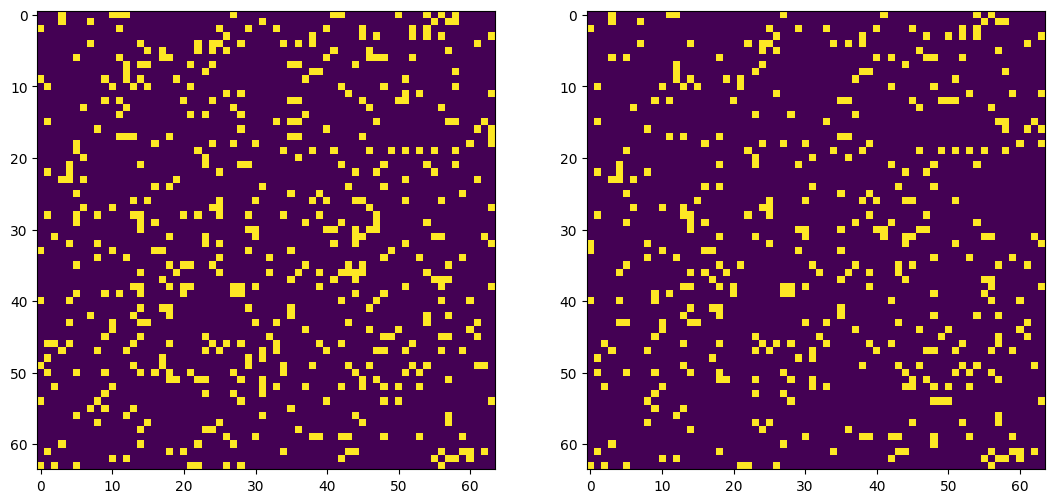

In [363]:
tens = torch.ones(50, 1, img_size[0], img_size[1])
images1 = net(tens)

tens = single_data(
            field_depth_m,
            field_height_m,
            fov_deg,
            camera_pos,
            output_length=50,
            img_size=img_size,
        ).image_sequence
images2 = net(tens)

for (img1, img2) in zip(images1, images2):
    live_imshow(
        img1.unflatten(0, (64, 64)).detach().numpy(),
        img2.unflatten(0, (64, 64)).detach().numpy(),
        figsize=(13, 13)
    )

In [ ]:
def live_plot_learning(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()

In [ ]:
train_net = create_training_set(100, num_steps, field_depth_m, field_height_m, fov_deg, camera_pos)
spike_recording = [] # record spikes over time
loss_stats = []


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

In [ ]:
num_epoch = 100

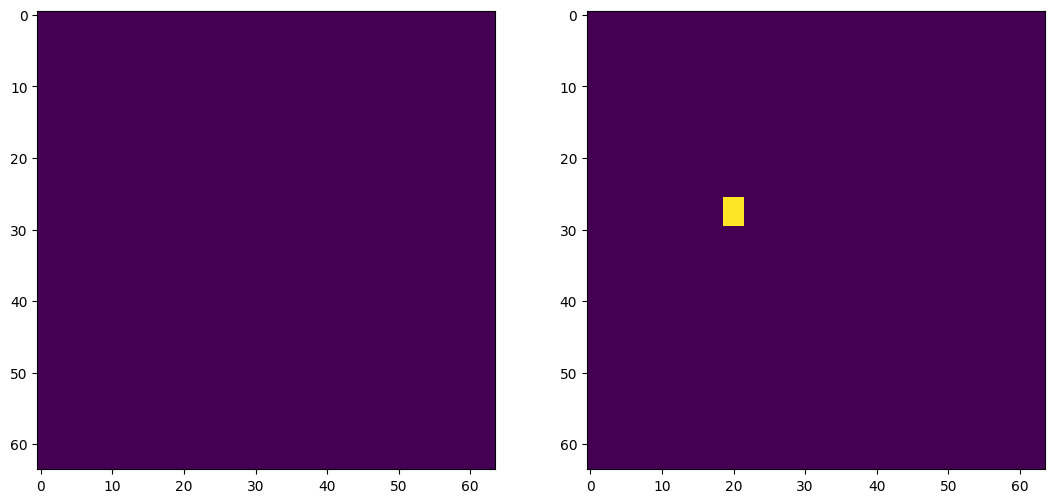

KeyboardInterrupt: 

In [357]:
net.train()
for epoch in range(num_epoch):
    random.shuffle(train_net)
    train_iter = iter(train_net)
    ep_loss = 0
    for i, data in enumerate(train_iter):
        target = data.image_sequence[-1][0].flatten()
        target[0] = 0

        for j in range(2, len(data.image_sequence)): # loop over time
            spikes = net(data.image_sequence[0 : j])[-1]
            loss = criterion(spikes, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ep_loss += loss.item()
            live_imshow(
                spikes.unflatten(0, (64, 64)).detach().numpy(),
                target.unflatten(0, (64, 64)).detach().numpy(),
                figsize=(13, 13)
            )

    print(ep_loss / (i * j + 1))
    loss_stats += [ep_loss / (i * j + 1)]
    live_plot_learning(loss_stats)


In [ ]:
def calc_err(spikes : list, target : int):
  cntr = 0
  for spike in spikes: 
    if spike.item() == target: cntr += 1
  return cntr / len(spikes)

net.eval()
random.shuffle(train_net)
avg_err = 0
for i, data in enumerate(iter(train_net)):
  target = torch.tensor([1 if data.crashes_flag else 0], dtype=torch.float32)
  loss = torch.zeros(1, dtype=torch.float32, device='cpu')
  spike = net(data.position_sequence)
  for step in spike[2:]: # loop over time
    # spike_recording.append(spike.item()) # record spikes in list
    loss += criterion(step, target)
    # loss_val += loss.item()
  avg_err += calc_err(spike[2:], target.item())
  print(calc_err(spike[2:], target.item()), spike.mean().item(), target.item())
print(avg_err / i)

Теперь тестируем точность с алгоритмической доработкой: проверяется плотность спайков на выходе и если она превышает 0.5, то будем считать, что авария предсказана вовремя.

In [ ]:
def predict_crash(spikes : torch.Tensor):
  return 1 if spikes.mean().item() > 0.5 else 0

In [ ]:
random.shuffle(train_net)
avg_acc = 0
for i, data in enumerate(iter(train_net)):
  target = 1 if data.crashes_flag else 0
  spike = net(data.position_sequence)
  avg_acc += 1 if predict_crash(spike[2:]) == target else 0
  print(avg_acc / (i + 1), predict_crash(spike[2:]), target)
print(avg_acc / (i + 1))